# Predicting success of a kickstarter

This notebook utilizes the Kickstarter data from Kaggle (https://www.kaggle.com/kemical/kickstarter-projects) to predict whether or not a project will be successfully funded.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, auc
from sklearn.metrics import accuracy_score, log_loss

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn import svm

plt.style.use('ggplot')
sns.set_style("whitegrid")
sns.set_palette('deep')
% matplotlib inline

/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


## Data Exploration

In [2]:
data = pd.read_csv('../data/ks-projects-201801.csv')

In [3]:
data.head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
0,1000002330,The Songs of Adelaide & Abullah,Poetry,Publishing,GBP,10/9/15,1000.0,8/11/15 12:12,0.0,failed,0,GB,0.0,0.0,1533.95
1,1000003930,Greeting From Earth: ZGAC Arts Capsule For ET,Narrative Film,Film & Video,USD,11/1/17,30000.0,9/2/17 4:43,2421.0,failed,15,US,100.0,2421.0,30000.00
2,1000004038,Where is Hank?,Narrative Film,Film & Video,USD,2/26/13,45000.0,1/12/13 0:20,220.0,failed,3,US,220.0,220.0,45000.00
3,1000007540,ToshiCapital Rekordz Needs Help to Complete Album,Music,Music,USD,4/16/12,5000.0,3/17/12 3:24,1.0,failed,1,US,1.0,1.0,5000.00
4,1000011046,Community Film Project: The Art of Neighborhoo...,Film & Video,Film & Video,USD,8/29/15,19500.0,7/4/15 8:35,1283.0,canceled,14,US,1283.0,1283.0,19500.00


In [4]:
data.columns

Index(['ID', 'name', 'category', 'main_category', 'currency', 'deadline',
       'goal', 'launched', 'pledged', 'state', 'backers', 'country',
       'usd pledged', 'usd_pledged_real', 'usd_goal_real'],
      dtype='object')

In [5]:
data.describe()

,ID,goal,pledged,backers,usd pledged,usd_pledged_real,usd_goal_real
count,3.786610e+05,3.786610e+05,3.786610e+05,378661.000000,3.748640e+05,3.786610e+05,3.786610e+05
mean,1.074731e+09,4.908079e+04,9.682979e+03,105.617476,7.036729e+03,9.058924e+03,4.545440e+04
std,6.190862e+08,1.183391e+06,9.563601e+04,907.185035,7.863975e+04,9.097334e+04,1.152950e+06
min,5.971000e+03,1.000000e-02,0.000000e+00,0.000000,0.000000e+00,0.000000e+00,1.000000e-02
25%,5.382635e+08,2.000000e+03,3.000000e+01,2.000000,1.698000e+01,3.100000e+01,2.000000e+03
50%,1.075276e+09,5.200000e+03,6.200000e+02,12.000000,3.947200e+02,6.243300e+02,5.500000e+03
75%,1.610149e+09,1.600000e+04,4.076000e+03,56.000000,3.034090e+03,4.050000e+03,1.550000e+04
max,2.147476e+09,1.000000e+08,2.033899e+07,219382.000000,2.033899e+07,2.033899e+07,1.663614e+08


### Categories

In [6]:
print('There are', data['category'].unique().size, 'categories.')

There are 159 categories.


Text(0.5,1,'Most common categories')

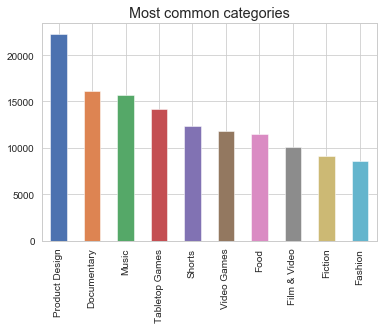

In [7]:
data['category'].value_counts()[0:10].plot.bar().set_title('Most common categories')

In [8]:
print('There are', data['main_category'].unique().size, 'main categories.')

There are 15 main categories.


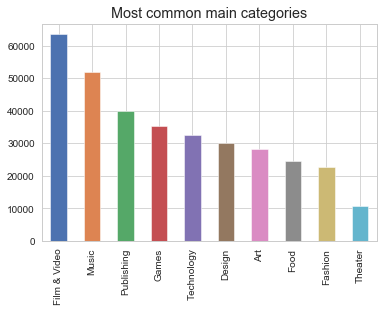

In [9]:
data['main_category'].value_counts()[0:10].plot.bar().set_title('Most common main categories')
plt.show()

In [10]:
groups = data.groupby(['main_category'])['category'].unique().to_frame()
groups['number_of_sub_categories'] = groups['category'].apply(lambda x: x.size)
groups.drop('category', axis=1, inplace = True)
groups = groups.sort_values(by = 'number_of_sub_categories')

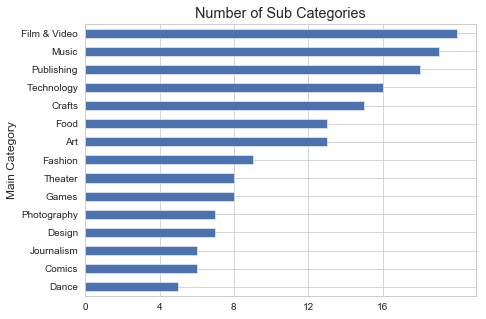

In [11]:
groups.plot.barh(legend=None, figsize=(7, 5))
plt.title('Number of Sub Categories')
plt.ylabel('Main Category')
plt.xticks(np.arange(0,20, step = 4))
plt.show()

### Currency

In [12]:
currency_counts = data['currency'].value_counts()

In [13]:
print(currency_counts.index[0], 'is the most represented currency, with', 
      currency_counts[0], 'instances.')

USD is the most represented currency, with 295365 instances.


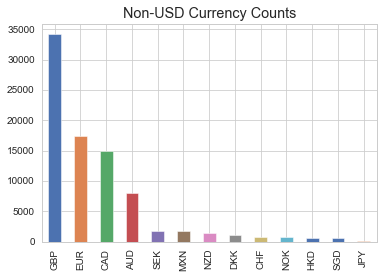

In [14]:
currency_counts.drop('USD').plot.bar()
plt.title('Non-USD Currency Counts')
plt.show()

### Date Launched

In [15]:
data['launched'] = pd.to_datetime(data['launched'])
year_launched = data['launched'].dt.year
year_launched.value_counts()

2015    77300
2014    67745
2016    57184
2017    52200
2013    44851
2012    41165
2011    26237
2010    10519
2009     1329
2018      124
1970        7
Name: launched, dtype: int64

In [16]:
index_1970 = data[data['launched'].dt.year == 1970].index
data.drop(index = index_1970, inplace = True)

In [17]:
data['year_launched'] = data['launched'].dt.year
data['year_launched'].value_counts()

2015    77300
2014    67745
2016    57184
2017    52200
2013    44851
2012    41165
2011    26237
2010    10519
2009     1329
2018      124
Name: year_launched, dtype: int64

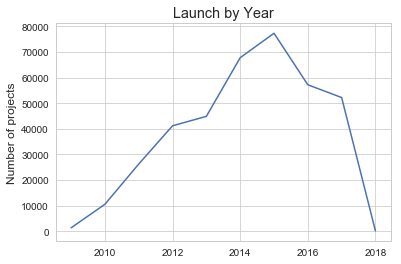

In [18]:
launched_counts = data['year_launched'].value_counts()
launched_counts = launched_counts.reindex(index = [2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018])
launched_counts.plot()
plt.title('Launch by Year')
plt.ylabel('Number of projects')
plt.show()

### Deadline

In [19]:
data['deadline'][0:5]

0    10/9/15
1    11/1/17
2    2/26/13
3    4/16/12
4    8/29/15
Name: deadline, dtype: object

In [20]:
data['deadline'] =  pd.to_datetime(data['deadline'], format='%m/%d/%y')
data['deadline_year'] = data['deadline'].dt.year

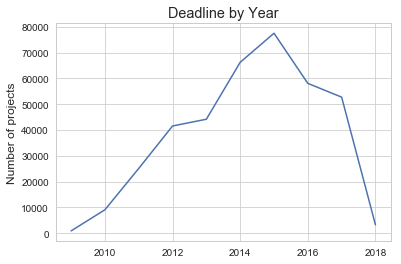

In [21]:
year_counts = data['deadline_year'].value_counts()
year_counts = year_counts.reindex(index = [2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018])
year_counts.plot()
plt.title('Deadline by Year')
plt.ylabel('Number of projects')
plt.show()

### Goal

**Goals over years**

In [22]:
data['goal'].describe()

count    3.786540e+05
mean     4.908160e+04
std      1.183402e+06
min      1.000000e-02
25%      2.000000e+03
50%      5.200000e+03
75%      1.600000e+04
max      1.000000e+08
Name: goal, dtype: float64

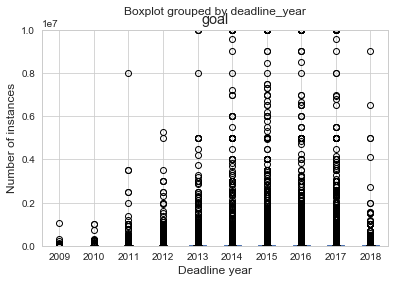

In [23]:
data.boxplot(column = ['goal'], by = ['deadline_year'])
plt.ylim(0, 10000000)
plt.xlabel('Deadline year')
plt.ylabel('Number of instances')
plt.show()

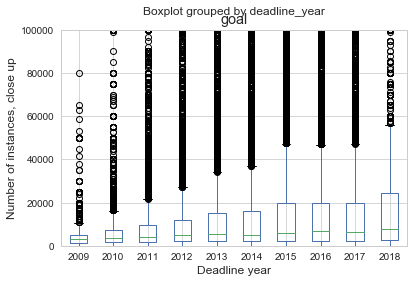

In [24]:
data.boxplot(column = ['goal'], by = ['deadline_year'])
plt.ylim(0, 100000)
plt.xlabel('Deadline year')
plt.ylabel('Number of instances, close up')
plt.show()

**Ranges of goals**

In [25]:
def split_ranges(x):
    if(x < 500):
        return '100 to 500'
    elif(500 <= x < 1000):
        return '500 to 1k'
    elif(1000 <= x < 5000):
        return '1k to 5k'
    elif(5000 <= x < 10000):
        return '5k to 10k'
    elif(10000 <= x < 50000):
        return '10k to 50k'
    elif(50000 <= x < 100000):
        return '50k to 100k'
    elif(100000 <= x < 500000):
        return '100k to 500k'
    elif(500000 <= x < 1000000):
        return '500k to 1m'
    else:
        return '1m+'

In [26]:
data['goal_range'] = data['goal'].apply(split_ranges)

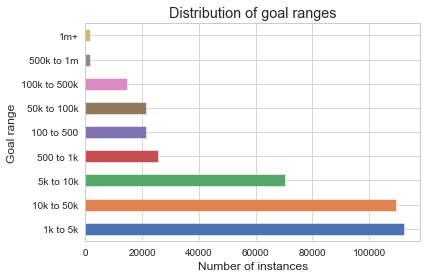

In [27]:
data['goal_range'].value_counts().plot.barh()
plt.xlabel('Number of instances')
plt.ylabel('Goal range')
plt.title('Distribution of goal ranges')
plt.show()

### Pledged

Text(0.5,1,'Amount Pledged')

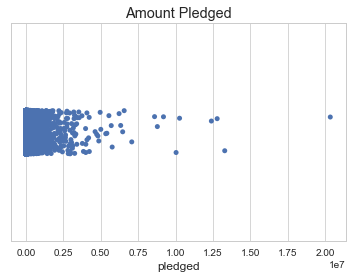

In [28]:
sns.stripplot(data['pledged'])
plt.title('Amount Pledged')

In [29]:
data[data['pledged'] > 20000000]

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real,year_launched,deadline_year,goal_range
157270,1799979574,"Pebble Time - Awesome Smartwatch, No Compromises",Product Design,Design,USD,2015-03-28,500000.0,2015-02-24 15:44:00,20338986.27,successful,78471,US,20338986.27,20338986.27,500000.0,2015,2015,500k to 1m


**Pledged by category**

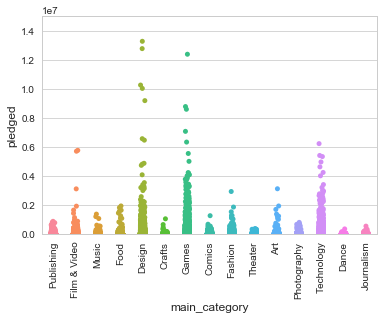

In [30]:
sns.stripplot(x = data['main_category'], y = data['pledged'])
plt.ylim(0, 15000000)
plt.xticks(rotation = 'vertical')
plt.show()

**Pledged by goal**

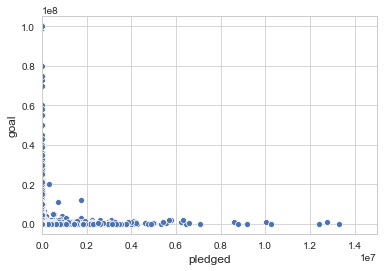

In [31]:
sns.scatterplot(x = 'pledged', y = 'goal', data = data)
plt.xlim(0, 15000000)
plt.show()

### State

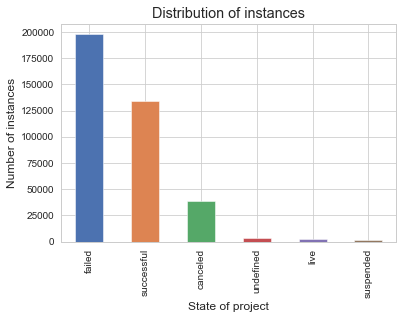

In [32]:
data['state'].value_counts().plot.bar()
plt.xlabel('State of project')
plt.ylabel('Number of instances')
plt.title('Distribution of instances')
plt.show()

**State by category**

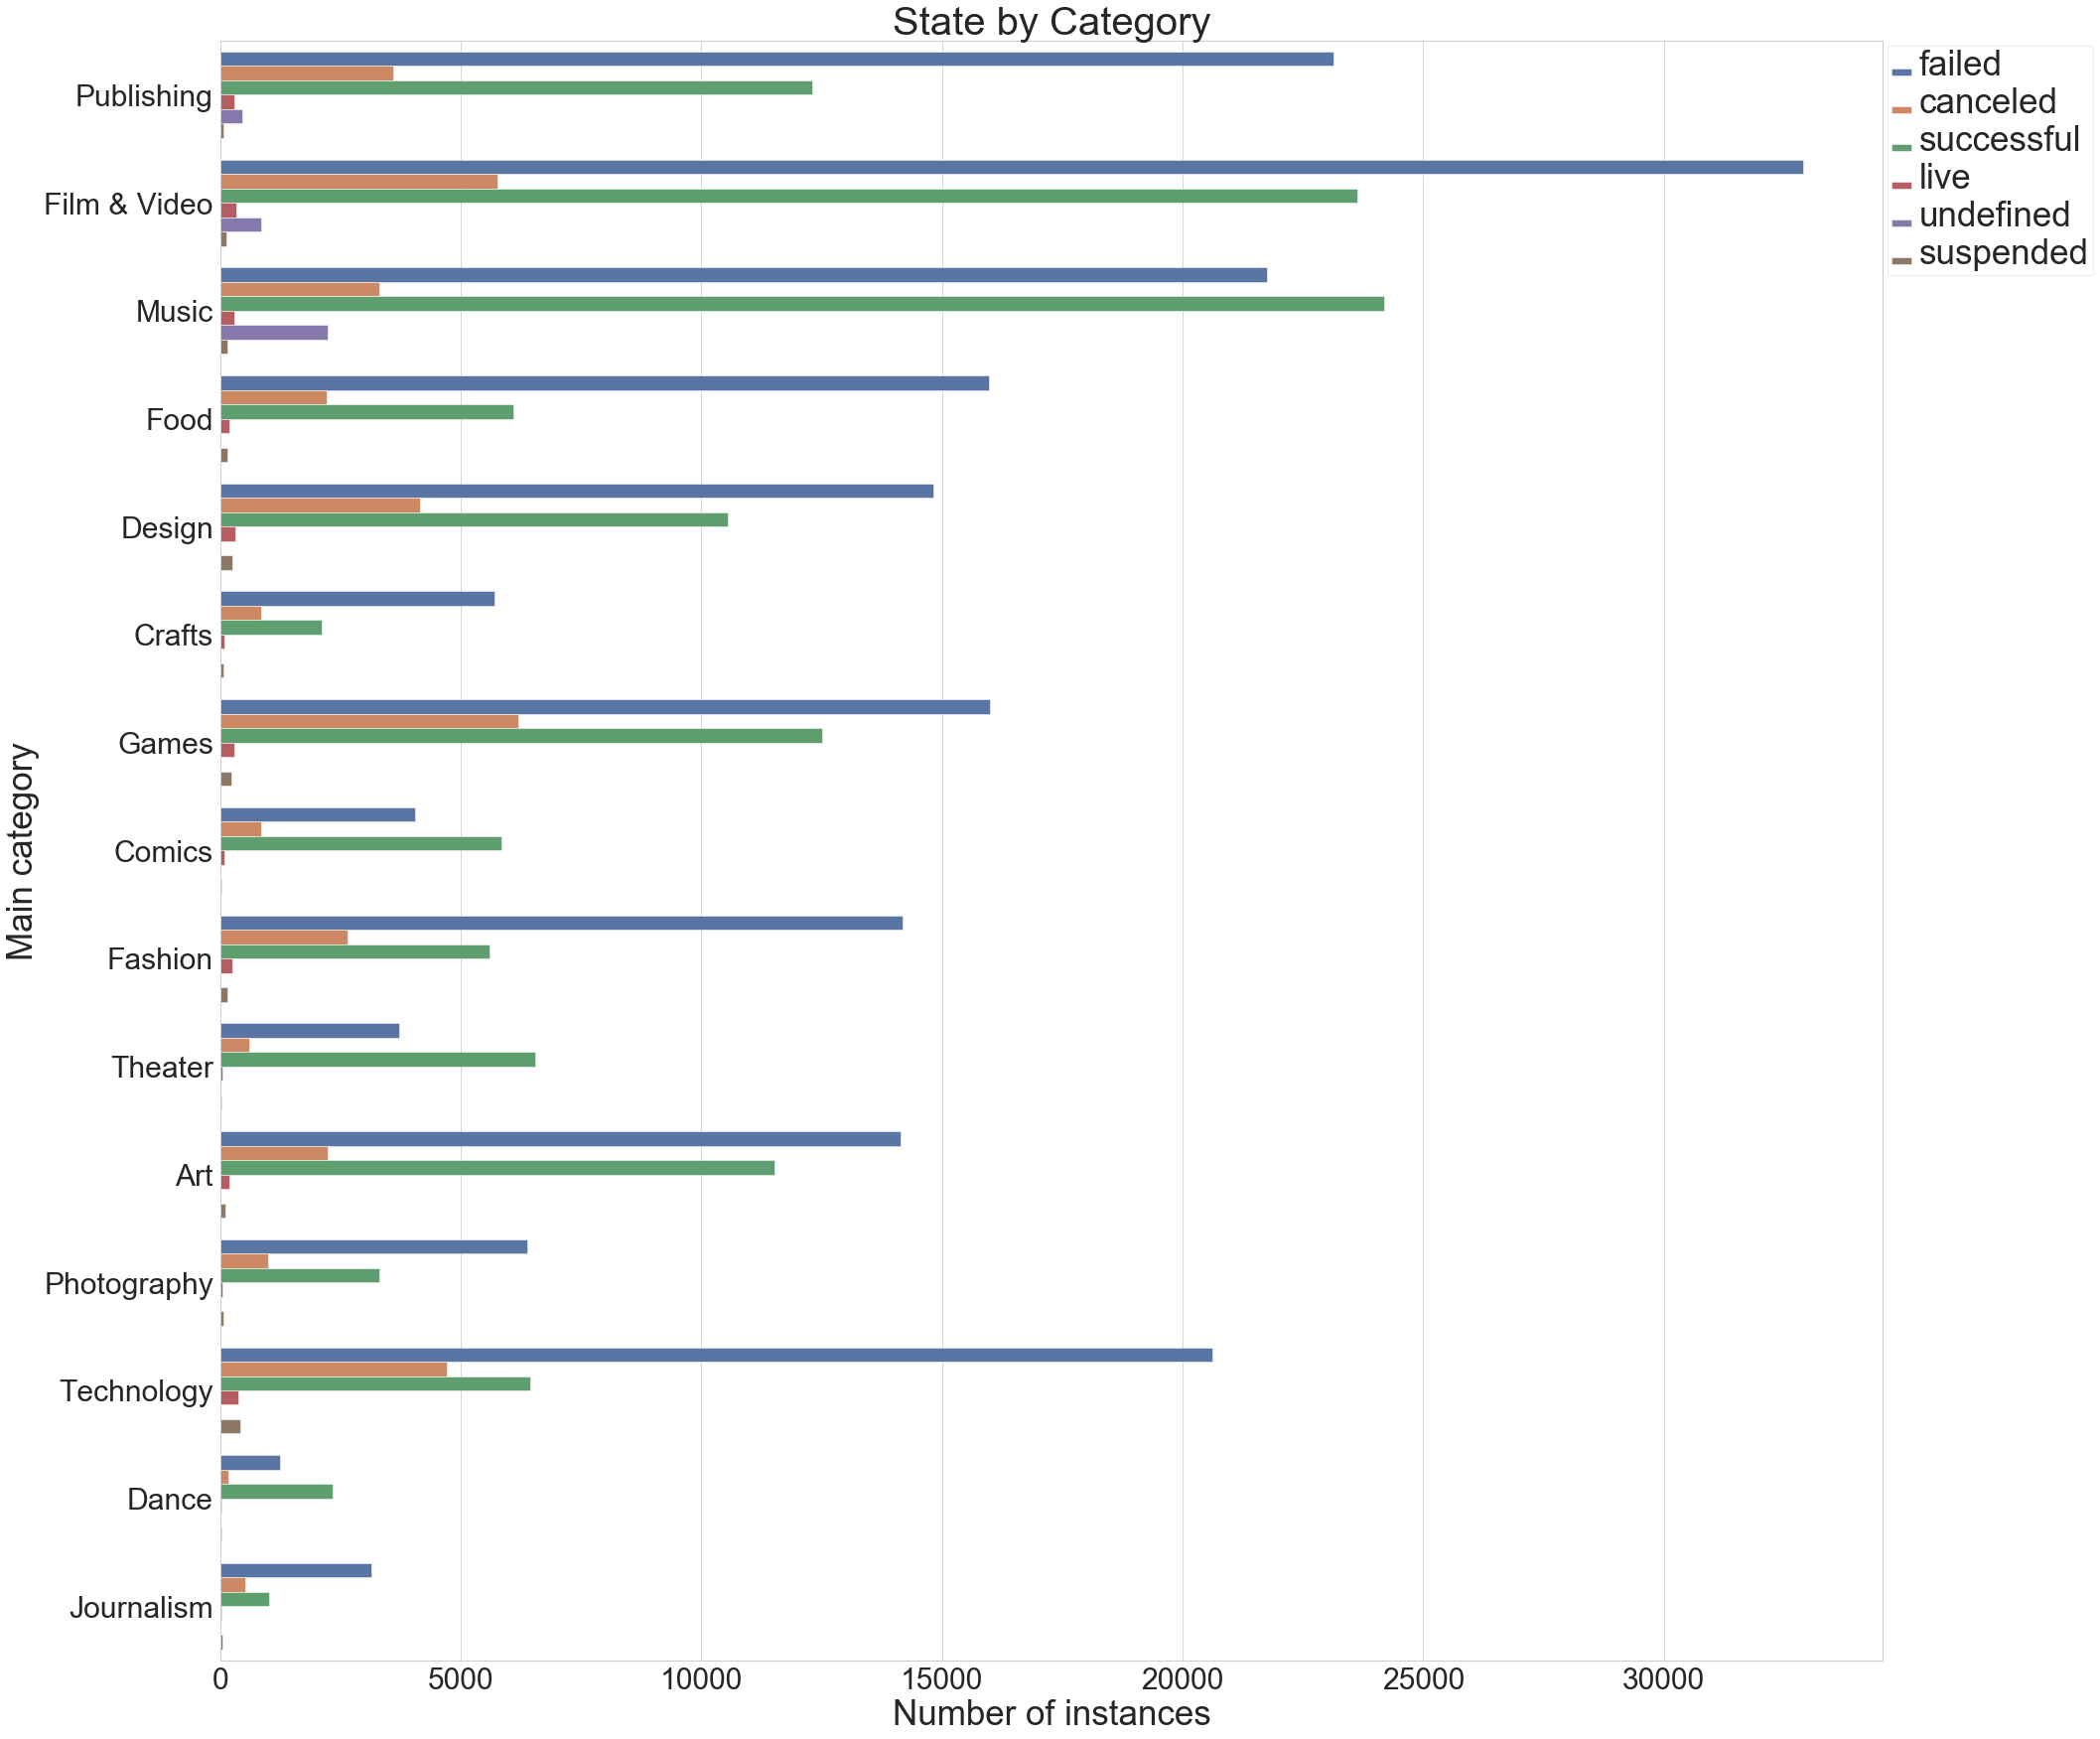

In [33]:
plt.figure(figsize=(30, 30))
ax = sns.countplot(y = 'main_category', hue = 'state', data = data)
ax.legend(bbox_to_anchor=(1, 1))
plt.title('State by Category', fontsize = 40)
plt.ylabel('Main category', fontsize = 35)
plt.xlabel('Number of instances', fontsize = 35)
plt.tick_params(axis='both', which='major', labelsize=30)
plt.tick_params(axis='both', which='minor', labelsize=30)
plt.setp(ax.get_legend().get_texts(), fontsize='35') 
plt.show()

**Distribution of states by category**

In [34]:
cat_by_state = data.groupby(['main_category', 'state'])['state'].count()
cat_pcts = cat_by_state.groupby(level=0).apply(lambda x: (x / x.sum()))
cat_pcts = cat_pcts.to_frame().unstack().fillna(0).round(2)

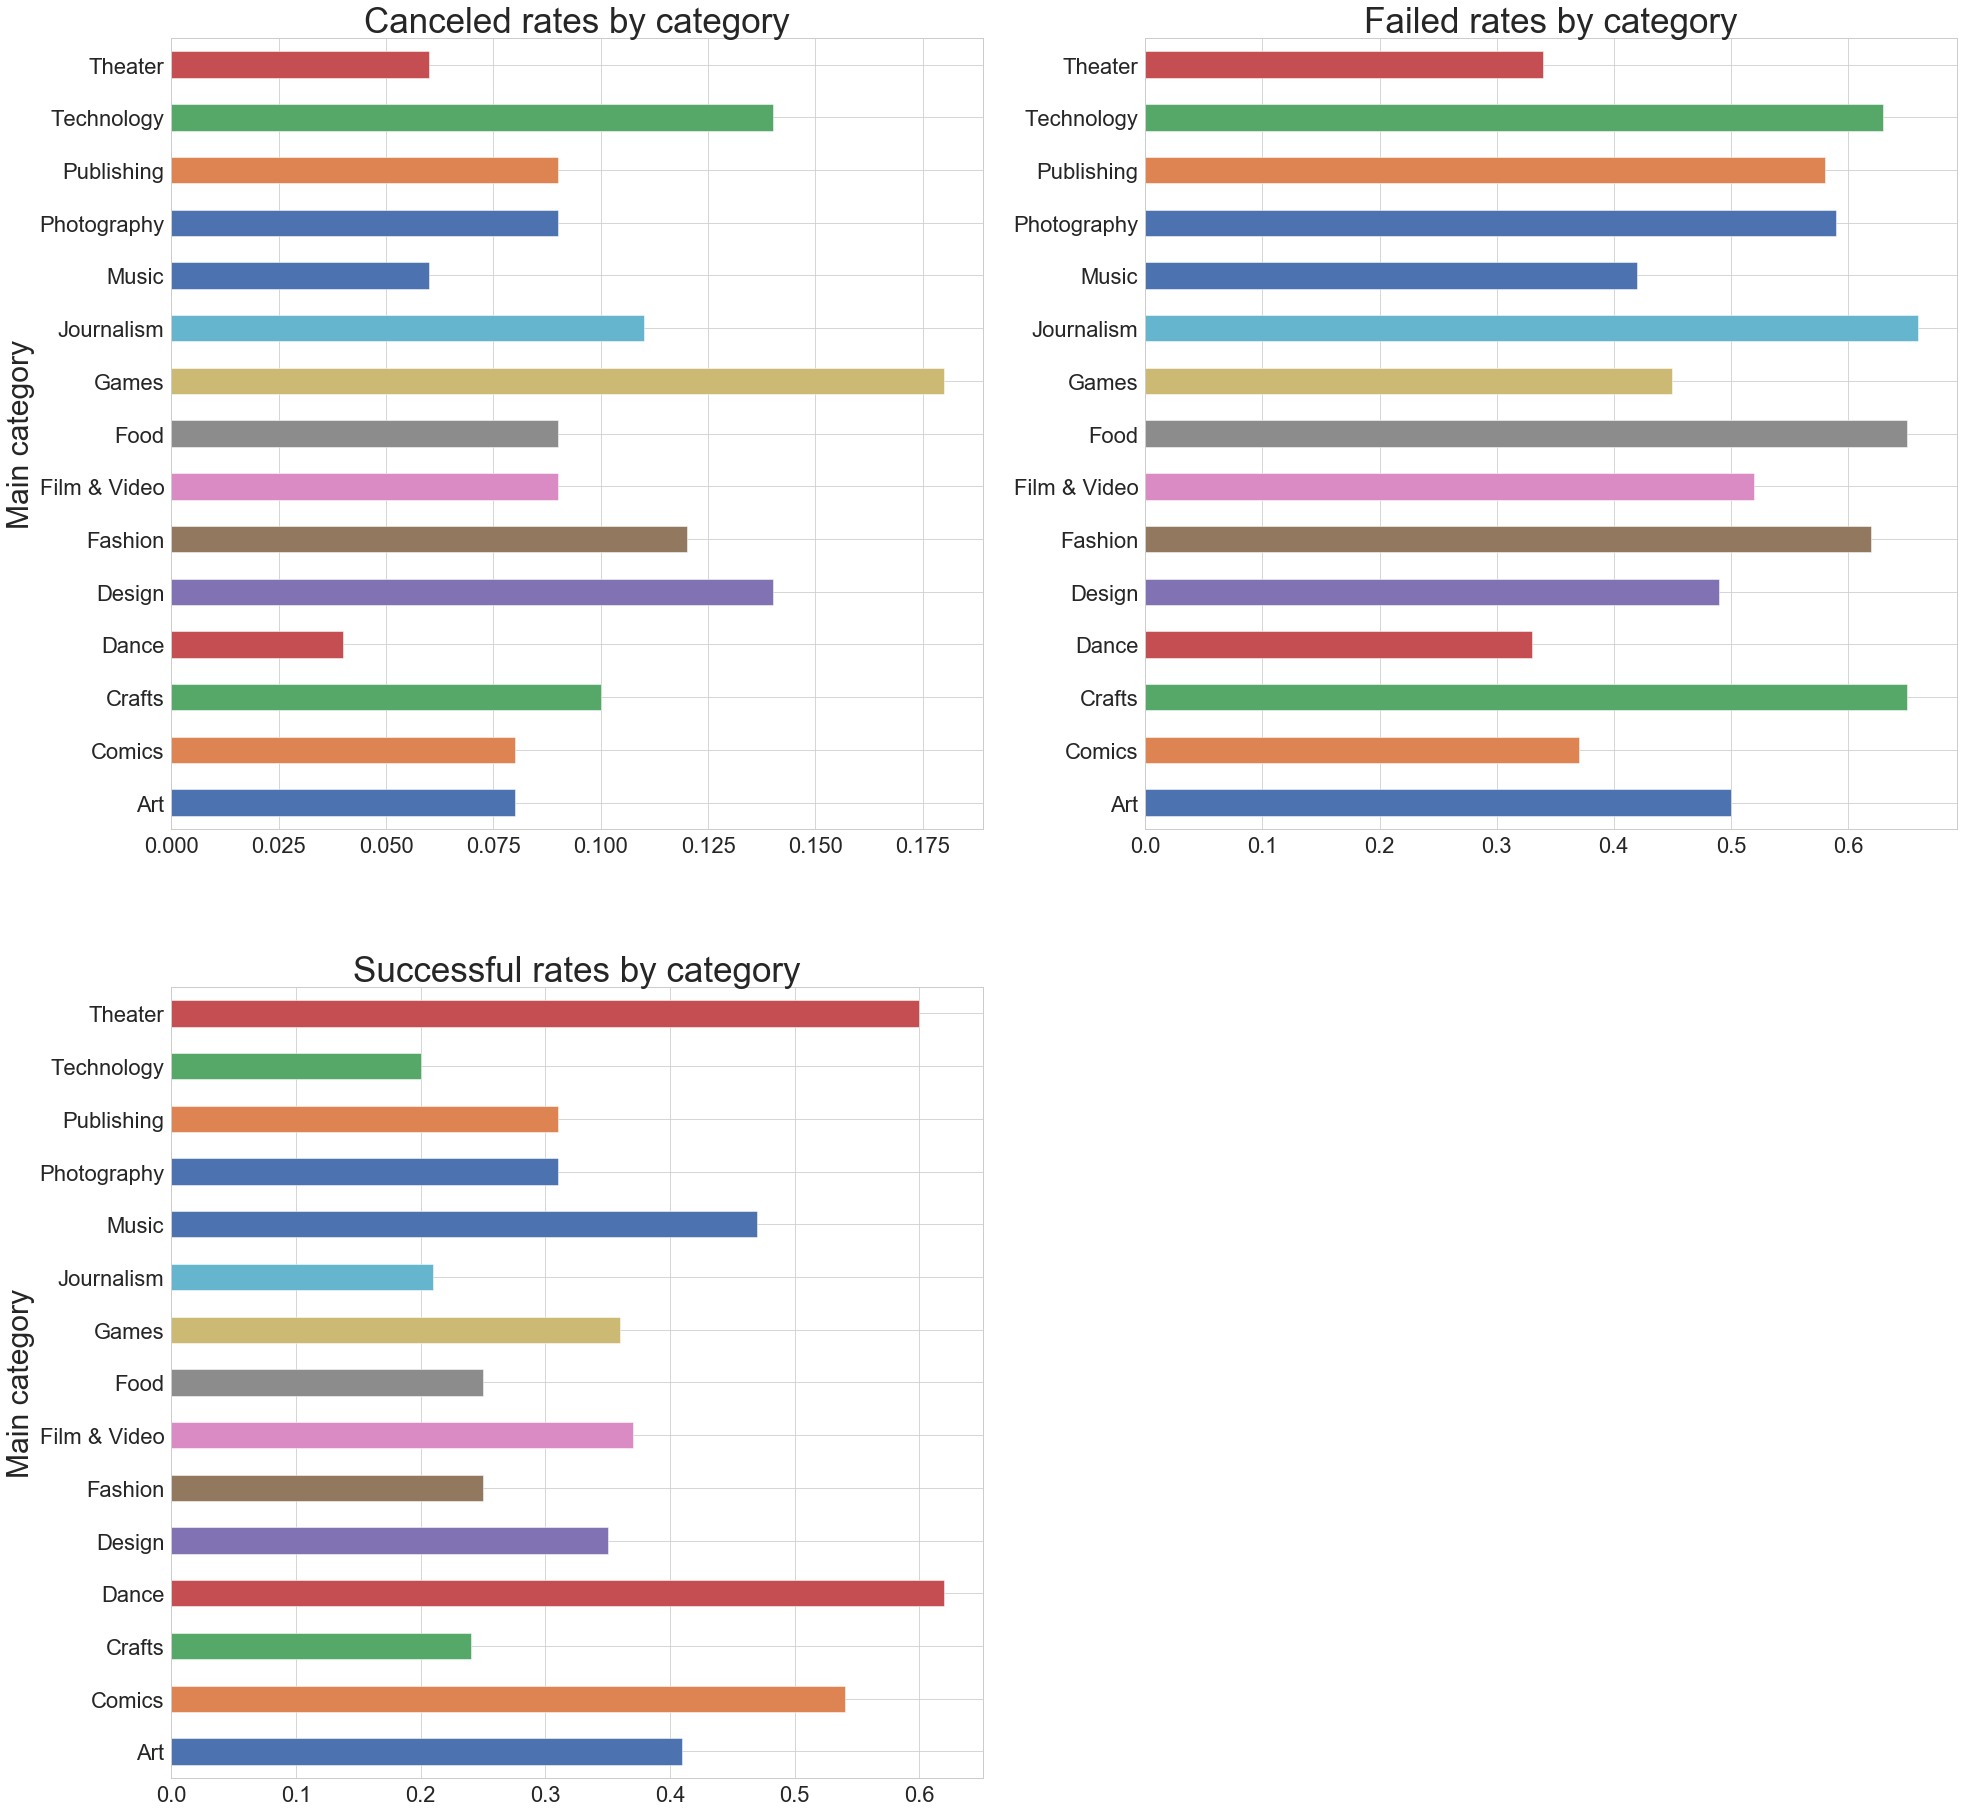

In [35]:
plt.figure(figsize=(32, 32))

plt.subplot(2, 2, 1)
cat_pcts.T.loc[['state'][0]].iloc[0].plot.barh() 
plt.tick_params(axis='both', which='major', labelsize=22)
plt.ylabel('Main category', fontsize = 30)
plt.title('Canceled rates by category', fontsize = 35)

plt.subplot(2, 2, 2) 
cat_pcts.T.loc[['state'][0]].iloc[1].plot.barh() 
plt.tick_params(axis='both', which='major', labelsize=22)
plt.ylabel('')
plt.title('Failed rates by category', fontsize = 35)

plt.subplot(2, 2, 3) #successful 
cat_pcts.T.loc[['state'][0]].iloc[3].plot.barh()
plt.tick_params(axis='both', which='major', labelsize=22)
plt.ylabel('Main category', fontsize = 30)
plt.title('Successful rates by category', fontsize = 35)

plt.show()

### Backers

**Distribution of backers**

In [36]:
data['backers'].describe()

count    378654.000000
mean        105.619428
std         907.193306
min           0.000000
25%           2.000000
50%          12.000000
75%          56.000000
max      219382.000000
Name: backers, dtype: float64

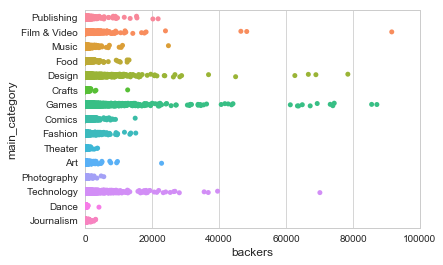

In [37]:
sns.stripplot(x = 'backers', y = 'main_category', data = data)
plt.xlim(0, 100000)
plt.show()

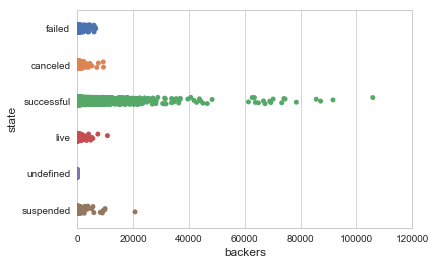

In [38]:
sns.stripplot(x = 'backers', y = 'state', data = data)
plt.xlim(0, 120000)
plt.show()

**Campaigns with the most backers**

In [39]:
backers_index = data['backers'].astype(int).sort_values(ascending = False).index
data.loc[backers_index][:5][['name', 'category', 'state', 'backers']].set_index('name')

,category,state,backers
name,,,
Exploding Kittens,Tabletop Games,successful,219382
Fidget Cube: A Vinyl Desk Toy,Product Design,successful,154926
"Bring Reading Rainbow Back for Every Child, Everywhere!",Web,successful,105857
The Veronica Mars Movie Project,Narrative Film,successful,91585
Double Fine Adventure,Video Games,successful,87142


*The country with the most counts is the United States. Excepting the United States, the top countries are:*

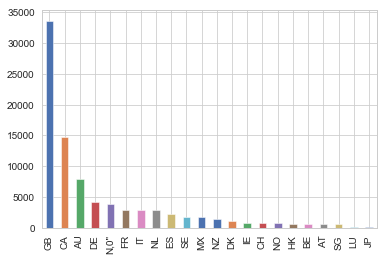

In [40]:
data['country'].value_counts().drop('US').plot.bar()

### Empty values

In [41]:
data.isna().sum()

ID                     0
name                   4
category               0
main_category          0
currency               0
deadline               0
goal                   0
launched               0
pledged                0
state                  0
backers                0
country                0
usd pledged         3797
usd_pledged_real       0
usd_goal_real          0
year_launched          0
deadline_year          0
goal_range             0
dtype: int64

In [42]:
data[data['name'].isna()]

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real,year_launched,deadline_year,goal_range
166851,1848699072,NaN,Narrative Film,Film & Video,USD,2012-02-29,200000.0,2012-01-01 12:35:00,100.0,failed,1,US,100.00,100.00,200000.00,2012,2012,100k to 500k
307234,634871725,NaN,Video Games,Games,GBP,2013-01-06,2000.0,2012-12-19 23:57:00,196.0,failed,12,GB,317.73,316.05,3224.97,2012,2013,1k to 5k
309991,648853978,NaN,Product Design,Design,USD,2016-07-18,2500.0,2016-06-18 05:01:00,0.0,suspended,0,US,0.00,0.00,2500.00,2016,2016,1k to 5k
338931,796533179,NaN,Painting,Art,USD,2011-12-05,35000.0,2011-11-06 23:55:00,220.0,failed,5,US,220.00,220.00,35000.00,2011,2011,10k to 50k


In [43]:
data[(data['usd pledged'].isna()) & 
     (data['state'] == 'successful')][['name', 'pledged', 'usd pledged', 'country']].head()

,name,pledged,usd pledged,country
2457,An Oratorio for our Time - Last Stop Cafe,5170.00,NaN,"N,0"""
4892,Jackson Ruby: The Cassette Album,5296.00,NaN,"N,0"""
5353,Help Parker Brown make his first solo album,5077.00,NaN,"N,0"""
5597,Help BETHANY record a NEW single in Nash!,3502.13,NaN,"N,0"""
8260,Serena Gabriel's first CD!!!!!!: Diving Deep,3787.00,NaN,"N,0"""


In [44]:
co_index = data[data['country'] == 'N,0"'].index

In [45]:
data.loc[co_index, 'country'] = ''

In [46]:
data['country'].unique()

array(['GB', 'US', 'CA', 'AU', 'NO', 'IT', 'DE', 'IE', 'MX', 'ES', '',
       'SE', 'FR', 'NL', 'NZ', 'CH', 'AT', 'DK', 'BE', 'HK', 'LU', 'SG',
       'JP'], dtype=object)

### Correlation

In [47]:
dropped_corr = data.corr().drop('ID').drop('ID', axis = 1)

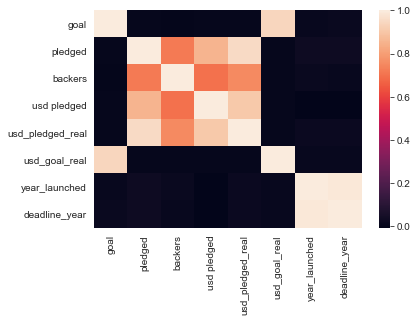

In [48]:
sns.heatmap(dropped_corr)

In [49]:
dropped_corr.stack()[data.corr().stack(
    ).between(0.5, 1, inclusive = False)]

goal              usd_goal_real       0.942692
pledged           backers             0.717079
                  usd pledged         0.857370
                  usd_pledged_real    0.952843
backers           pledged             0.717079
                  usd pledged         0.697426
                  usd_pledged_real    0.752539
usd pledged       pledged             0.857370
                  backers             0.697426
                  usd_pledged_real    0.907743
usd_pledged_real  pledged             0.952843
                  backers             0.752539
                  usd pledged         0.907743
usd_goal_real     goal                0.942692
year_launched     deadline_year       0.990963
deadline_year     year_launched       0.990963
dtype: float64

## Cleaning data, feature engineering

In [50]:
#for name: punctuation, stopwords, stem, BOW

#other: percentile buckets?

**Extract workable columns**

In [51]:
clean_data = data.copy()

clean_data = clean_data.drop(['ID', 
                              'pledged', 'usd pledged', 'goal', 
                             'deadline_year', 'year_launched'], 
                             axis = 1)

In [52]:
new_cols = ['name', 'sub_category', 'main_category', 'currency', 
            'deadline', 'launched', 'state', 'backers', 'country', 
            'usd_pledged', 'usd_goal', 'goal_range']

clean_data.columns = new_cols

In [53]:
clean_data.dropna(inplace = True)

**Map state**

In [54]:
clean_data = clean_data[(clean_data['state'] == 'successful') 
                        | (clean_data['state'] == 'failed')]

In [55]:
def to_int(x):
    if(x == 'successful'):
        return 1
    else:
        return 0

In [56]:
clean_data['state'] = clean_data['state'].apply(to_int)

In [57]:
clean_data.corr()['state'].drop('state')

backers        0.125790
usd_pledged    0.108298
usd_goal      -0.023735
Name: state, dtype: float64

In [58]:
clean_data.sample()

,name,sub_category,main_category,currency,deadline,launched,state,backers,country,usd_pledged,usd_goal,goal_range
220466,I Am Jack's Apocalypse,Thrillers,Film & Video,USD,2014-07-27,2014-06-29 01:40:00,0,32,US,4036.0,15000.0,10k to 50k


### Features from project names

**Length of names**

In [59]:
clean_data['name_length'] = clean_data['name'].str.len()

In [60]:
clean_data['name_length'].describe()[['mean', 'std', 'min', 'max']]

mean    34.216889
std     15.963648
min      1.000000
max     85.000000
Name: name_length, dtype: float64

In [61]:
clean_data[clean_data['name_length'] == 1].sample()['name']

212923    H
Name: name, dtype: object

In [62]:
pd.set_option('display.max_colwidth', -1)

clean_data[clean_data['name_length'] == 85].sample()['name']

250799    Desert Uncles: A (Rock)umentary about YV and Brother K's First Tour/Southeast Odyssey
Name: name, dtype: object

In [63]:
# split words in the name?

#kick_projects['name_words'] = 
#kick_projects.name.apply(lambda x: len(str(x).split(' ')))

### Pledge per backer

In [64]:
clean_data['pledge_per_backer'] = clean_data['usd_pledged'] / clean_data['backers']


In [65]:
clean_data['pledge_per_backer'] = clean_data['pledge_per_backer'].fillna(0).astype(float).round(0)

In [66]:
clean_data['pledge_per_backer'].replace(np.inf, 0, inplace = True)

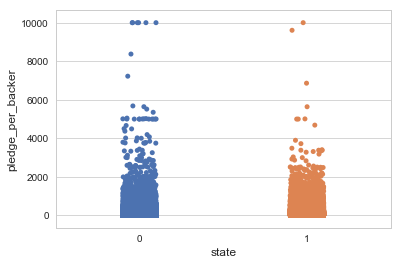

In [67]:
sns.stripplot(y = 'pledge_per_backer', x = 'state', data = clean_data)
plt.show()

In [68]:
clean_data.columns

Index(['name', 'sub_category', 'main_category', 'currency', 'deadline',
       'launched', 'state', 'backers', 'country', 'usd_pledged', 'usd_goal',
       'goal_range', 'name_length', 'pledge_per_backer'],
      dtype='object')

### One hot encode categorical columns

In [69]:
clean_data = pd.get_dummies(clean_data, columns = ['main_category', 'sub_category'])

In [70]:
clean_data = pd.get_dummies(clean_data, columns = ['currency', 'country'])

In [71]:
list(clean_data.columns)

['name',
 'deadline',
 'launched',
 'state',
 'backers',
 'usd_pledged',
 'usd_goal',
 'goal_range',
 'name_length',
 'pledge_per_backer',
 'main_category_Art',
 'main_category_Comics',
 'main_category_Crafts',
 'main_category_Dance',
 'main_category_Design',
 'main_category_Fashion',
 'main_category_Film & Video',
 'main_category_Food',
 'main_category_Games',
 'main_category_Journalism',
 'main_category_Music',
 'main_category_Photography',
 'main_category_Publishing',
 'main_category_Technology',
 'main_category_Theater',
 'sub_category_3D Printing',
 'sub_category_Academic',
 'sub_category_Accessories',
 'sub_category_Action',
 'sub_category_Animals',
 'sub_category_Animation',
 'sub_category_Anthologies',
 'sub_category_Apparel',
 'sub_category_Apps',
 'sub_category_Architecture',
 'sub_category_Art',
 'sub_category_Art Books',
 'sub_category_Audio',
 'sub_category_Bacon',
 'sub_category_Blues',
 'sub_category_Calendars',
 'sub_category_Camera Equipment',
 'sub_category_Candles',


In [72]:
clean_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 331672 entries, 0 to 378660
Columns: 221 entries, name to country_US
dtypes: datetime64[ns](2), float64(3), int64(3), object(2), uint8(211)
memory usage: 104.6+ MB


In [73]:
#decided to take out goal_range as well

clean_data.drop('goal_range', axis = 1, inplace = True)

In [74]:
clean_data.iloc[:2,:9]

,name,deadline,launched,state,backers,usd_pledged,usd_goal,name_length,pledge_per_backer
0,The Songs of Adelaide & Abullah,2015-10-09,2015-08-11 12:12:00,0,0,0.0,1533.95,31,0.0
1,Greeting From Earth: ZGAC Arts Capsule For ET,2017-11-01,2017-09-02 04:43:00,0,15,2421.0,30000.00,45,161.0


### Extract data from datetime columns

**Deadline**

In [75]:
clean_data['deadline_year'] = clean_data['deadline'].dt.year
clean_data['deadline_month'] = clean_data['deadline'].dt.month
clean_data['deadline_day'] = clean_data['deadline'].dt.day
clean_data['deadline_day_of_week'] = clean_data['deadline'].dt.dayofweek

In [76]:
clean_data.drop('deadline', axis = 1, inplace = True)

**Launched**

In [77]:
clean_data['launched_year'] = clean_data['launched'].dt.year
clean_data['launched_month'] = clean_data['launched'].dt.month
clean_data['launched_day'] = clean_data['launched'].dt.day
clean_data['launched_day_of_week'] = clean_data['launched'].dt.dayofweek
clean_data['launched_hour'] = clean_data['launched'].dt.hour

In [78]:
clean_data.drop('launched', axis = 1, inplace = True)

**Normalize data attributes**

In [79]:
clean_data.drop('name', axis = 1, inplace = True)

In [80]:
clean_data = clean_data.fillna(0)
clean_data.replace(np.inf, 0, inplace = True)
scaled_clean_data = clean_data.copy()

In [81]:
scaler = StandardScaler()

In [82]:
scaled_clean_data.iloc[:, 1:6] = scaler.fit_transform(scaled_clean_data.iloc[:, 1:6])
scaled_clean_data.head()

,state,backers,usd_pledged,usd_goal,name_length,pledge_per_backer,main_category_Art,main_category_Comics,main_category_Crafts,main_category_Dance,...,country_US,deadline_year,deadline_month,deadline_day,deadline_day_of_week,launched_year,launched_month,launched_day,launched_day_of_week,launched_hour
0,0,-0.120550,-0.102794,-0.036049,-0.201514,-0.502156,0,0,0,0,...,0,2015,10,9,4,2015,8,11,1,12
1,0,-0.105013,-0.077766,-0.010379,0.675480,0.721165,0,0,0,0,...,1,2017,11,1,2,2017,9,2,5,4
2,0,-0.117443,-0.100519,0.003147,-1.266435,0.052518,0,0,0,0,...,1,2013,2,26,1,2013,1,12,5,0
3,0,-0.119514,-0.102783,-0.032923,0.926050,-0.494558,0,0,0,0,...,1,2012,4,16,0,2012,3,17,5,3
5,1,0.111471,0.438644,0.007656,-0.890580,1.275838,0,0,0,0,...,1,2016,4,1,4,2016,2,26,4,13


## Modeling

**Using Gradient Boosting, Random Forest, and Logistic Regression**

**Data Prep**

In [83]:
y = scaled_clean_data['state']
y.value_counts()

0    197716
1    133956
Name: state, dtype: int64

In [84]:
x = scaled_clean_data.drop('state', axis = 1)

In [85]:
X_train, X_test, y_train, y_test = train_test_split(
x, y, random_state = 10)

In [86]:
print(X_train.shape, y_train.shape)

(248754, 225) (248754,)


In [87]:
print(X_test.shape, y_test.shape)

(82918, 225) (82918,)


**Gradient Boosting Classifier**

*Training model*

In [88]:
gb = GradientBoostingClassifier()
gb.fit(X_train, y_train)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

*Evaluate model*

In [89]:
print("Classification report: \n" )

predictions  = gb.predict(X_test)
print(classification_report(y_test, predictions))

Classification report: 

             precision    recall  f1-score   support

          0       1.00      0.98      0.99     49510
          1       0.98      1.00      0.99     33408

avg / total       0.99      0.99      0.99     82918



In [90]:
print("Confusion matrix: \n" )

print(confusion_matrix(y_test, predictions))

Confusion matrix: 

[[48758   752]
 [    5 33403]]


In [91]:
gb_accuracy = accuracy_score(y_test, predictions)
print(gb_accuracy)

0.9908704985648472


In [92]:
gb_importances = pd.DataFrame(gb.feature_importances_, 
                              index = X_train.columns, columns = 
                              ['GB Importance'])

gb_importances.sort_values(by = 'GB Importance', 
                           inplace = True, ascending = False)
gb_importances.head()

,GB Importance
usd_pledged,0.475087
usd_goal,0.357460
backers,0.129932
pledge_per_backer,0.013084
main_category_Film & Video,0.005627


In [93]:
gb.get_params

<bound method BaseEstimator.get_params of GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)>

In [94]:
parameters = {
    "n_estimators": [100, 300, 500],
    "learning_rate": [0.01, 0.05, 0.1, 0.2],
    "min_samples_split": np.linspace(0.1, 0.5, 3),
    "min_samples_leaf": np.linspace(0.1, 0.5, 3),
    "max_depth":[3,5,8],
    }

In [95]:
clf = GridSearchCV(GradientBoostingClassifier(), parameters, cv = 3, 
                   verbose = 2)

In [96]:
#clf.fit(X_train, y_train)

In [97]:
#print(clf.score(X_train, y_train))
#print(clf.best_params_)

**Random Forest Classifier**

In [98]:
clf = RandomForestClassifier(n_jobs = -1)

In [99]:
clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [100]:
print("Confusion matrix: \n" )

predictions  = clf.predict(X_test)
print(confusion_matrix(y_test, predictions))

Confusion matrix: 

[[48327  1183]
 [  777 32631]]


In [101]:
rfc_accuracy = accuracy_score(y_test, predictions)
print(rfc_accuracy)

0.9763621891507273


In [102]:
rfc_importances = pd.DataFrame(clf.feature_importances_,
                        index = X_train.columns, columns = 
                               ['RFC Importance'])

rfc_importances.sort_values(by = 'RFC Importance', 
                           inplace = True, ascending = False)
rfc_importances.head()

,RFC Importance
usd_pledged,0.280802
backers,0.274989
usd_goal,0.185691
pledge_per_backer,0.090053
name_length,0.015517


*Does cutting down the number of features improve performance?*

In [103]:
rfc_importances.index[:10]

Index(['usd_pledged', 'backers', 'usd_goal', 'pledge_per_backer',
       'name_length', 'launched_day', 'deadline_day', 'launched_hour',
       'launched_month', 'deadline_month'],
      dtype='object')

In [104]:
X_train_cut = X_train[rfc_importances.index[:20]]

In [105]:
X_test_cut = X_test[rfc_importances.index[:20]]

In [106]:
clf2 = RandomForestClassifier(n_jobs = -1)

In [107]:
clf2.fit(X_train_cut, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [108]:
print("Confusion matrix: \n" )

predictions2  = clf2.predict(X_test_cut)
print(confusion_matrix(predictions2, y_test))

Confusion matrix: 

[[49172   152]
 [  338 33256]]


In [109]:
rfc_cut_accuracy = accuracy_score(y_test, predictions2)
print(rfc_cut_accuracy)

0.9940905472876818


In [110]:
print('Comparing accuracy across models done so far')

pd.Series([gb_accuracy, rfc_accuracy, rfc_cut_accuracy], index = 
         ['gradient boost', 'random forest', 'random forest cut'])

Comparing accuracy across models done so far


gradient boost       0.990870
random forest        0.976362
random forest cut    0.994091
dtype: float64

**Logistic Regression**

In [111]:
lr = LogisticRegression()

In [112]:
#using the cut back features, since that worked so well above

lr.fit(X_train_cut, y_train)
predictions3 = lr.predict(X_test_cut)
lr_accuracy = accuracy_score(predictions3, y_test)
print(lr_accuracy)

#oh dear, not very good

0.8214742275501098


In [113]:
lr2 = LogisticRegression()

In [114]:
lr2.fit(X_train, y_train)
predictions4 = lr2.predict(X_test)
lr_accuracy2 = accuracy_score(predictions4, y_test)
print(lr_accuracy2)

#interesting that random forest is better with less features, but logistic regression isn't

0.8465351310933693


### Looping through models

In [115]:
from sklearn.svm import SVC

In [116]:
classifiers = [
    RandomForestClassifier(), 
    GaussianNB(), 
    LogisticRegression(),
    GradientBoostingClassifier(), 
    #SVC()
]

log_cols = ['Classifier', 'Accuracy', 'Log Loss']
log = pd.DataFrame(columns = log_cols)

In [117]:
for clf in classifiers:
    clf.fit(X_train, y_train)
    name = clf.__class__.__name__
    
    print('-'*10)
    print(name)
    
    train_predictions = clf.predict(X_test)
    acc = accuracy_score(y_test, train_predictions)
    print('Accuracy:', acc)
    
    train_predictions = clf.predict_proba(X_test)
    ll = log_loss(y_test, train_predictions)
    print('Log loss:', ll)

----------
RandomForestClassifier
Accuracy: 0.9754215007597867
Log loss: 0.11996685836682021
----------
GaussianNB
Accuracy: 0.5966858824380713
Log loss: 7.5900142825578785
----------
LogisticRegression
Accuracy: 0.8465351310933693
Log loss: 0.40011136822799065
----------
GradientBoostingClassifier
Accuracy: 0.9908704985648472
Log loss: 0.03886672122746923


## Utilizing the name column

In [380]:
import re
from nltk.corpus import stopwords

In [381]:
named_data = data[['name', 'state']]

named_data = named_data[(named_data['state'] == 'failed') | 
                        (named_data['state'] == 'successful')]

named_data['state'] = named_data['state'].apply(to_int)

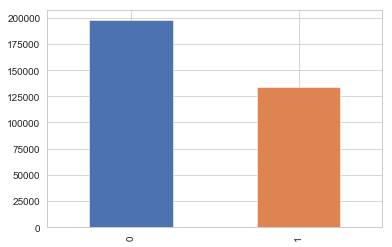

In [382]:
named_data['state'].value_counts().plot.bar()
plt.show()

**Cleaning data**

In [393]:
def name_to_words(raw_name):
    letters_only = re.sub("[^a-z^A-Z]", " ", raw_name)
    words = letters_only.lower().split()
    stops = set(stopwords.words('english')) 
        #searching a set is faster than searching a list
    return [w for w in words if not w in stops]

In [384]:
named_data['name'].fillna('', inplace = True)

In [385]:
named_data['cleaned_name'] = named_data['name'].apply(name_to_words)

named_data[['name', 'cleaned_name']][1:4]

,name,cleaned_name
1,Greeting From Earth: ZGAC Arts Capsule For ET,greeting earth zgac arts capsule et
2,Where is Hank?,hank
3,ToshiCapital Rekordz Needs Help to Complete Album,toshicapital rekordz needs help complete album


**Pipeline / Model w Sklearn's Vectorizers**

In [415]:
from sklearn.pipeline import Pipeline

In [416]:
X_train, X_test, y_train, y_test = \
train_test_split(named_data['cleaned_name'], named_data['state'])

In [418]:
#Logistic Regression

pipeline = Pipeline([
    ('bow', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('classifier', LogisticRegression())
])

pipeline.fit(X_train, y_train)
predictions = pipeline.predict(X_train)

In [425]:
print('Logistic Regression Results: \n')
print(confusion_matrix(y_train, predictions), '\n')
print(classification_report(y_train, predictions))

Logistic Regression Results: 

[[130501  17877]
 [ 51247  49131]] 

             precision    recall  f1-score   support

          0       0.72      0.88      0.79    148378
          1       0.73      0.49      0.59    100378

avg / total       0.72      0.72      0.71    248756



In [426]:
#Random Forest

pipeline = Pipeline([
    ('bow', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('classifier', RandomForestClassifier())
])

pipeline.fit(X_train, y_train)

In [429]:
predictions = pipeline.predict(X_train)

print('Random Forest Results: \n')
print(confusion_matrix(y_train, predictions), '\n')
print(classification_report(y_train, predictions))

Random Forest Results: 

[[146871   1507]
 [  6821  93557]] 

             precision    recall  f1-score   support

          0       0.96      0.99      0.97    148378
          1       0.98      0.93      0.96    100378

avg / total       0.97      0.97      0.97    248756

